# Stage 14 — Deployment & Monitoring (Filled Notebook)

This notebook completes the Stage 14 homework:
- Risks & failure modes
- Concrete monitoring plan across **Data / Model / System / Business**
- **Metrics & thresholds**, owners, alert routes, first runbook step
- Python helpers for **AUC**, **p95 latency**, and a tiny **PSI** drift function
- Dashboard wireframe (saved to `deliverables/images/dashboard_sketch.png`)
- Retraining cadence & triggers
- Final deliverables checklist

## 1) Risks & Failure Modes (3–5)
1. **Schema drift** — columns added/renamed/types changed; downstream breaks or silent misprocessing.  
2. **Null spikes / bad imputations** — missingness increases; metrics degrade or bias creeps in.  
3. **Feature distribution shift** — seasonality/promotions/new cohorts shift inputs; scores drift.  
4. **Label delay/bias** — evaluation lags or skews; online metrics diverge from truth.  
5. **Traffic spikes / dependency issues** — upstream outages/load increase **p95 latency** and error rate.

## 2) Monitoring Plan (Data / Model / System / Business)

| Layer | Metrics | Thresholds / Triggers | Action & Ownership |
|------|---------|------------------------|--------------------|
| **Data** | Schema hash, per-feature null rate, freshness (mins), **PSI** on key features | schema mismatch; nulls > **2%** abs or **3×** baseline; freshness > **30m**; PSI warn **≥0.10**, act **≥0.20** | **DE** on-call; fix feeds; re-run ingest/validate |
| **Model** | Rolling 14d **AUC**/**MAE** by segment; calibration (ECE); score p5/p95 bounds | AUC < **0.62** for 7 days or MAE +**15%** vs baseline; ECE > **0.05** | **DS/ML** on-call; investigate drift; consider shadow retrain |
| **System** | **p95 latency**, error rate, throughput/capacity, job success | p95 > **400 ms** for 15 min; error rate > **0.5%** | **SRE/Platform**; scale/rollback; incident process |
| **Business** | Approval/Conversion, Revenue per 1k req, Overrides/Complaints | conv ±**5 pts**; rev/1k ±**10%**; overrides > **2%** | **PM/Analytics**; policy review; stakeholder comms |

### Notes
- **PSI** (Population Stability Index) flags covariate shift; pair with segment slices.  
- **AUC** monitors separability for binary outcomes; complement with calibration (**ECE**).  
- **p95 latency** focuses on the tail; averages can hide user pain.

In [1]:
# 3) Metric Helpers: AUC, p95 latency, and a tiny PSI drift function
import numpy as np
from sklearn.metrics import roc_auc_score

def p95_latency(latencies_ms: np.ndarray) -> float:
    latencies_ms = np.asarray(latencies_ms, dtype=float)
    return float(np.percentile(latencies_ms, 95))

def demo_auc(y_true, y_score):
    """Compute AUC; y_true in {0,1}, y_score are probabilities or scores."""
    return float(roc_auc_score(y_true, y_score))

def psi(actual: np.ndarray, expected: np.ndarray, bins: int = 10) -> float:
    """Simple PSI using equal-width bins on expected range (for quick drift checks)."""
    actual = np.asarray(actual, dtype=float)
    expected = np.asarray(expected, dtype=float)
    eps = 1e-9
    lo, hi = np.nanmin(expected), np.nanmax(expected)
    edges = np.linspace(lo, hi + eps, bins + 1)
    def hist_pct(x):
        h, _ = np.histogram(x, bins=edges)
        p = h / max(1, len(x))
        p = np.where(p == 0, 1e-6, p)  # avoid zeros
        return p
    p_act = hist_pct(actual)
    p_exp = hist_pct(expected)
    return float(np.sum((p_act - p_exp) * np.log(p_act / p_exp)))

In [2]:
# 4) Mini Demonstration of Metrics (synthetic data)
np.random.seed(14)

# AUC demo
y_true = np.random.randint(0, 2, size=500)
y_score_good = y_true * 0.7 + (1 - y_true) * 0.3 + np.random.normal(0, 0.05, size=500)
auc_val = demo_auc(y_true, y_score_good)
print(f"AUC (demo): {auc_val:.3f}")

# p95 latency demo
lat_ms = np.concatenate([np.random.normal(120, 20, size=950), np.random.normal(450, 50, size=50)])
print(f"p95 latency (ms): {p95_latency(lat_ms):.1f}")

# PSI demo (expected vs actual feature distributions)
expected_feat = np.random.normal(0, 1, size=1000)
actual_feat   = np.random.normal(0.2, 1.1, size=1000)
print(f"PSI (demo): {psi(actual_feat, expected_feat):.3f}  ->  warn ≥ 0.10, act ≥ 0.20")

AUC (demo): 1.000
p95 latency (ms): 202.9
PSI (demo): 0.077  ->  warn ≥ 0.10, act ≥ 0.20


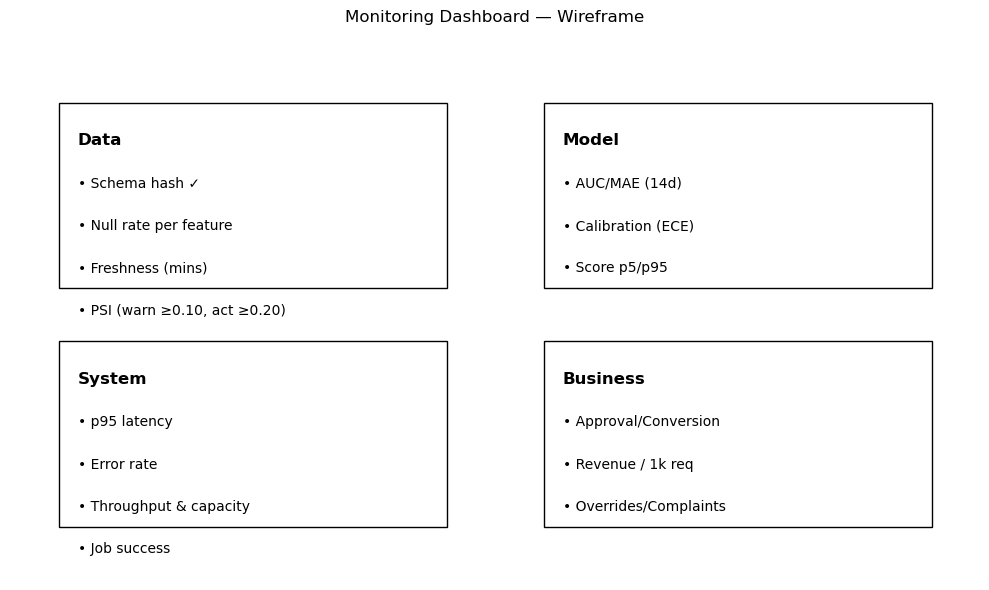

Saved: deliverables/images/dashboard_sketch.png


In [3]:
# 5) Dashboard Wireframe — exports PNG to deliverables/images
import matplotlib.pyplot as plt
from pathlib import Path

IMG = Path("deliverables/images")
IMG.mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots(figsize=(10,6))
ax.set_axis_off()
ax.set_title("Monitoring Dashboard — Wireframe", pad=20)

def panel(ax, x, y, w, h, title, lines):
    rect = plt.Rectangle((x,y), w, h, fill=False)
    ax.add_patch(rect)
    ax.text(x+0.02, y+h-0.08, title, fontsize=12, fontweight='bold')
    for i, t in enumerate(lines):
        ax.text(x+0.02, y+h-0.16-0.08*i, f"• {t}", fontsize=10)

panel(ax, 0.05, 0.55, 0.4, 0.35, "Data",
      ["Schema hash ✓", "Null rate per feature", "Freshness (mins)", "PSI (warn ≥0.10, act ≥0.20)"])
panel(ax, 0.55, 0.55, 0.4, 0.35, "Model",
      ["AUC/MAE (14d)", "Calibration (ECE)", "Score p5/p95"])
panel(ax, 0.05, 0.10, 0.4, 0.35, "System",
      ["p95 latency", "Error rate", "Throughput & capacity", "Job success"])
panel(ax, 0.55, 0.10, 0.4, 0.35, "Business",
      ["Approval/Conversion", "Revenue / 1k req", "Overrides/Complaints"])

plt.tight_layout()
out_path = IMG / "dashboard_sketch.png"
plt.savefig(out_path.as_posix(), dpi=160)
plt.show()
print("Saved:", out_path.as_posix())

## 6) Ownership & Handoffs

| Layer | Primary Owner | Secondary | Alert Route | Runbook Link |
|------|----------------|-----------|-------------|--------------|
| Data | Data Engineering | DS | Slack `#ml-alerts` | `/runbooks/data.md` |
| Model | DS/ML Eng | PM/Analytics | Slack + Pager (Sev-1) | `/runbooks/model.md` |
| System | SRE/Platform | DS | PagerDuty | `/runbooks/system.md` |
| Business | PM/Analytics | DS | Slack `#biz-ops` | `/runbooks/business.md` |

**First runbook step:** Freeze deploys, capture snapshot (model/data versions, traffic, recent releases), identify which layer triggered, then follow the respective runbook.

## 7) Retraining Cadence & Triggers
- **Cadence:** Monthly, or sooner if drift/quality triggers fire.  
- **Triggers:** PSI **≥ 0.20** on **≥2** key features **or** 2-week rolling **AUC < 0.60**; consider MAE +15% vs baseline.  
- **Promotion path:** Shadow evaluation → blue/green rollout with 10% canary → full traffic after SLOs stable.

## 8) Deliverables Checklist (Stage 14)
- ✅ Risks & failure modes (3–5)  
- ✅ Monitoring plan across **Data/Model/System/Business** with **metrics & thresholds**  
- ✅ **AUC/p95** code examples and a simple **PSI** helper  
- ✅ Dashboard wireframe image exported to `deliverables/images/dashboard_sketch.png`  
- ✅ Ownership table, alert routes, first runbook step  
- ✅ Retraining triggers and promotion approach